# Vivarium coding tutorial
### Eran Agmon
__Overview:__ this notebook covers examples of how to build vivarium processes, how to combine multiple processes in a composite, and how to simulate the composite in an experiment. Every example has a minimal use cases, and some more advanced variations. These require an intermediate understanding of object-oriented programming and Python. 

__Note:__ when this notebook is viewed as a presentation, many hidden functions and settings are skipped for clarity.

# Outline
 1. Make a Process
 2. Make a Composite
 3. Multi-paradigm composites
 
See the Vivarium Documentation for more complete instructions and tutorials: [https://vivarium-core.readthedocs.io/en/latest/](https://vivarium-core.readthedocs.io/en/latest/)

# Installation
 * All non-bioscrape processes shown in this notebook can be run independently with vivarium-core and vivarium-cell:
```console
> pip install vivarium-core
> pip install vivarium-cell
```
 * To run the bioscrape code, clone vivarium-bioscrape ([https://github.com/BuildACell/vivarium-bioscrape](https://github.com/BuildACell/vivarium-bioscrape)) and run the notebook from within the repository.
 * The vivarium-bioscrape README ([https://github.com/BuildACell/vivarium-bioscrape/blob/master/README.md](https://github.com/BuildACell/vivarium-bioscrape/blob/master/README.md)) describes how to use a local installation of bioscrape ([https://github.com/biocircuits/bioscrape](https://github.com/biocircuits/bioscrape)).


In [1]:
# import the vivarium process and generator interfaces
from vivarium.core.process import Process, Generator

# helper functions for composition
from vivarium.core.composition import (
    simulate_process_in_experiment,
    simulate_compartment_in_experiment,
    compartment_in_experiment,
    compose_experiment,
    GENERATORS_KEY)

# other vivarium imports
from vivarium.core.experiment import Experiment, pp
from vivarium.library.units import units

# vivarium plotting functions
from vivarium.plots.simulation_output import plot_simulation_output
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium.plots.topology import plot_compartment_topology

# other imports
import pylab as plt
import numpy as np

# suppress warnings
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

# 1. Make a Process
**Processes** are the basic building blocks of Vivarium. They can implement any kind of dynamical model - dynamic flux balance analysis, differential equation, stochastic process, Boolean logic, etc.

The process interface requires the following protocol:
1. A *constructor* that accepts parameters and configures the model.
2. A *ports_schema* that declares the ports and their schema.
3. A *next_update* that runs the model and returns an update.

<img src="images/process.png" width=300/>

# Example: Exponential Growth process
 * We here make a minimal process takes a mass variable $m$ and grows it with an exponential function. 
 * Noise $\xi$ is added to growth rate $k$ to support heterogeneity.
 * This process is used later in this notebook to make a composite.
 
\begin{equation}
\Delta m = m e^{(k+\xi)\Delta t}
\end{equation}

# Process constructor
 * Parameters passed into the constructor initialize the process, and override default parameter values.
 * This supports easy access for learning algorithms to adjust parameters.

In [2]:
class ExponentialGrowthExample(Process):

    defaults = {
        'growth_rate': 0.0005,
        'growth_noise': 1e-4}
    
    def __init__(self, parameters=None):
        super(ExponentialGrowthExample, self).__init__(parameters)

# Advanced constructor
 * Here, a bioscrape simulator is wrapped in a Process, allowing it to plug together with other processes.
 * `'time_step'` parameter declares the process' expected timescale.
 * `{'_parallel': True}` makes this process run as a parallel process.

In [3]:
from bioscrape.types import Model

class ExampleBioscrapeWrapper(Process):
    
    defaults = {
        'time_step': 0.1,
        '_parallel': True,
        'sbml_file': 'model.xml'}
    
    def __init__(self, parameters=None):
        super(ExampleBioscrape, self).__init__(parameters)
        
        # load the sbml file to create the model
        self.model = Model(sbml_filename=self.parameters['sbml_file'])

# ports_schema
 * Returns a dictionary with the ports ('port1') mapped to their expected variables ('mass').
 * Each variable assigns 'schema' settings that determine how that variable will behave.
    * `'_default'`, `'_value'`, `'_updater'`, `'_divider'`, `'_emit'`, `'_serializer'`, `'_properties'`

In [4]:
def ports_schema():
    return {
        'port1': {
            'mass': {
                '_default': 1000.0 * units.fg,
                '_updater': 'set',
                '_divider': 'split',
                '_emit': True}}}

# Advanced ports_schema
* Schema can also be declared by passing in functions.
* The `asymmetric_division` divider makes molecules in the `'front'` go to one daughter cell upon division, and those in the `'back'` go to the other daughter.

In [5]:
def asymmetric_division(value, topology):
    if 'front' in topology:
        return [value, 0.0]
    elif 'back' in topology:
        return [0.0, value]

def ports_schema():
    return {
        'front': {
            'molecule': {
                '_divider': {
                    'divider': asymmetric_division,
                    'topology': {'front': ('molecule',)},
                }}},
        'back': {
            'molecule': {
                '_divider': {
                    'divider': asymmetric_division,
                    'topology': {'back': ('molecule',)},
                }}}}

# next_update
 * This function represents the dynamical model.
 * Takes the current states and a timestep, and returns an update.

In [6]:
def next_update(timestep, states):
    
    # 1. Retrieve states at the start of the timestep
    mass = states['port1']['mass']

    # 2. Apply the mechanism for the timestep's duration
    new_mass = mass * (
        np.exp(self.growth_rate + np.random.normal(0, self.growth_noise)
              ) * timestep)

    # 3. The update is returned through the ports
    return {
        'port1': {
            'mass': new_mass}}

# The full ExponentialGrowth process, which is used later in this notebook

In [7]:
class ExponentialGrowth(Process):

    name = 'exponential_growth'
    defaults = {
        'growth_rate': 0.0005,
        'growth_noise': 1e-4}
    
    def __init__(self, parameters=None):
        super(ExponentialGrowth, self).__init__(parameters)
    
    def ports_schema(self):
        return {
            'port1': {
                'mass': {
                    '_default': 1000.0 * units.fg,
                    '_updater': 'set',
                    '_divider': 'split',
                    '_emit': True}}}
    

    def next_update(self, timestep, states):
        mass = states['port1']['mass']
        new_mass = mass * (
            np.exp(self.parameters['growth_rate'] +
                   np.random.normal(0,self.parameters['growth_noise'])
                  ) * timestep)
        return {
            'port1': {
                'mass': new_mass}}

# Simulate the ExponentialGrowth process
 * Each process can run on its own. This allows users to perfect their process before integrating with other processes.

In [8]:
# settings for running exponential growth process

growth_sim_settings = {
    'total_time': 2000,
    'initial_state': {'globals': {'mass': 1000 * units.fg}},
    'display_info': False,
    'progress_bar': False}

def plot_exponential_growth(data): 
    plt.figure()
    plt.plot(data['port1']['mass'], label = 'mass')
    plt.xlabel('time (s)')
    plt.ylabel('mass (fg)')

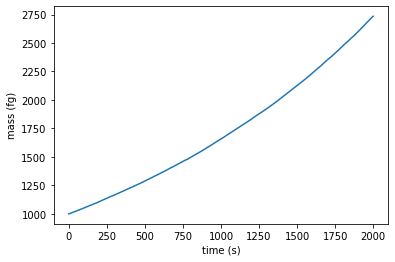

In [9]:
growth_parameters = {'growth_rate': 0.0005}
growth_process = ExponentialGrowth(growth_parameters)
sim_output = simulate_process_in_experiment(growth_process, growth_sim_settings)
plot_exponential_growth(sim_output)

# 2. Make a Composite
**Composites** are bundles of processes linked through their ports by a **topology**. Stores are automatically constructed based on the declared schema of the included processes.

A composite requires the following methods:
1. `generate_processes`: returns a dictionary of the initialized processes.
2. `generate_topology`: returns a dictionary that declares how processes are wired to shared stores. 

<img src="images/topology.png" width=500/>

# Example: GrowDivide composite
 * ExponentialGrowth is combined with additional processes to make a composite that grows exponentially and divides upon passing a mass threshold.

## Imported processes
 * `DeriveGlobals`: calculates shape variables such as volume, length, and width, assuming parameters from *E. coli*.
 * `DivideCondition`: triggers division upon declared condition.
 * `MetaDivision`: does the division, terminating the initial composite and launching two daughter instances.

In [10]:
from vivarium.processes.divide_condition import DivideCondition
from vivarium.processes.meta_division import MetaDivision
from vivarium_cell.processes.derive_globals import DeriveGlobals

# Composite constructor
 * Composite are initialized by passing in parameters, which override the defaults.

In [11]:
class GrowDivideExample(Generator):
    
    defaults = {
        'exponential_growth': {
            'growth_noise': 1e-3,
        },
        'divide_condition': {
            'threshold': 2000 * units.fg,
        }}

    def __init__(self, parameters):
        super(GrowDivideExample, self).__init__(parameters)

# generate_processes
 * Returns a dictionary mapping process names to instantiated process objects.
 * `config` is a dictionary of options, which can include process parameters.

In [12]:
def generate_processes(config):
    
    # ExponentialGrowth and DivideCondition are passed parameters from config
    return {
        'exponential_growth': ExponentialGrowth(config['exponential_growth']),
        'divide_condition': DivideCondition(config['divide_condition']),
        'globals_deriver': DeriveGlobals({}),
        'division': MetaDivision(division_config)}

# generate_topology
 * Returns a topology, which maps the ports of each process to a store name.
 * Here, exponential_growth's port1 is mapped to a store called boundary.

In [13]:
def generate_topology(config):
    
    return {
        'exponential_growth': {
            'port1': ('boundary',),
        },
        'globals_deriver': {
            'global': ('boundary',),
        },
        'divide_condition': {
            'variable': ('boundary', 'mass',),
            'divide': ('boundary', 'divide',),
        },
        'division': {
            'global': ('boundary',),
            'agents': ('cells',),
        }}

# Advanced topology: embedding in a hierarchy and splitting ports
 * To connect a process to sub-stores in the hierarchy, declare the path through each substore, as done to `'lipids'`.
 * To connect to supra-stores use `'..'` for each level up, as done to `'external'`.
 * One port can connect to multiple stores by specifying the path for each variable, as is done to `'transport'`.
     * This approach can also rename variables for easy integration of models with different names for the same variable.

In [14]:
def generate_topology(config):

    return {
        'process_1': {
            'lipids': ('organelle','membrane','lipid'),
            'external': ('..','environment'),
            'transport': {
                'glucose_external': ('external', 'glucose'),
                'glucose_internal': ('internal', 'glucose'),
            }
        }}

# The complete GrowthDivision composite, which is used in later slides


In [15]:
class GrowDivide(Generator):
    name = 'grow_divide'
    defaults = {
        'agent_id': np.random.randint(0,100),
        'exponential_growth': {'growth_noise': 1e-3},
        'divide_condition': {'threshold': 2000 * units.fg},
        'agents_path': ('..', '..', 'agents',),
        'daughter_path': tuple()}

    def __init__(self, config):
        super(GrowDivide, self).__init__(config)
    
    def generate_processes(self, config):
        division_config = dict(
            daughter_path=config['daughter_path'], 
            agent_id=config['agent_id'], 
            compartment=self)
        return {
            'exponential_growth': ExponentialGrowth(config['exponential_growth']),
            'divide_condition': DivideCondition(config['divide_condition']),
            'globals_deriver': DeriveGlobals({}),
            'division': MetaDivision(division_config)}

    def generate_topology(self, config):
        return {
            'exponential_growth': {
                'port1': ('boundary',)},
            'globals_deriver': {
                'global': ('boundary',)},
            'divide_condition': {
                'variable': ('boundary', 'mass',),
                'divide': ('boundary', 'divide',)},
            'division': {
                'global': ('boundary',),
                'agents': config['agents_path']}}

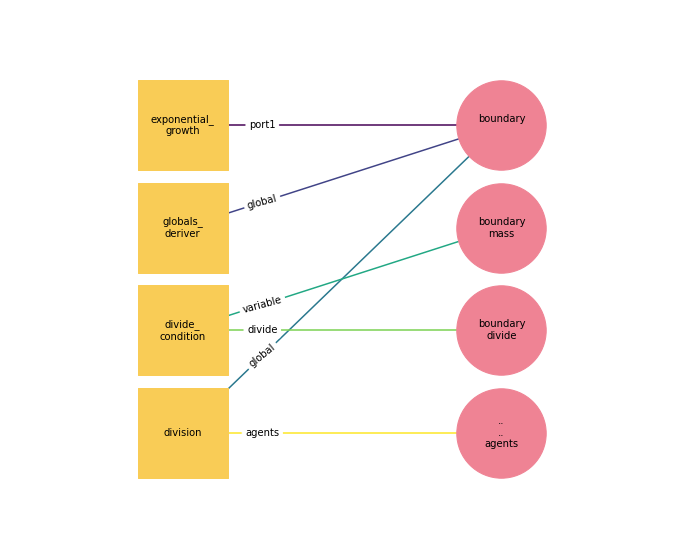

In [16]:
gd = GrowDivide({})
fig = plot_compartment_topology(gd)

# Simulate GrowDivide

In [17]:
# GrowDivide requires an 'agent_id' for the division process to track agents
agent_id = '0'
gd_params = {
    'agent_id': agent_id,
    'growth_rate': {
        'growth_rate': 0.001}}

initial_state = {
    'agents': {
        agent_id: {
            'mass': 1000 * units.fg}}}

gd_sim_settings = {
    'initial_state': initial_state,
    'outer_path': ('agents', agent_id),
    'display_info': False,
    'progress_bar': False}

gd_plot_settings = {
    'column_width': 12,
    'include_paths': [
        ('boundary', 'mass')]}

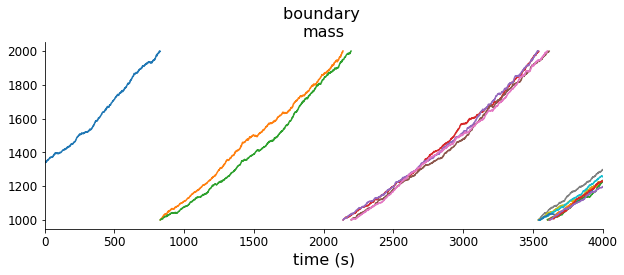

In [18]:
# initialize GrowDivide with parameters
gd_composite = GrowDivide(gd_params)

# make the experiment
gd_experiment = compartment_in_experiment(gd_composite, gd_sim_settings)

# run for 4000 seconds and retrieve the data
gd_experiment.update(4000)
gd_data = gd_experiment.emitter.get_data()

# plot output
fig = plot_agents_multigen(gd_data, gd_plot_settings)

# Simulate GrowDivide within a Lattice Environment Compartment
 * We here plug GrowDivide into a composite called Lattice, which has a multi-body physics process (MBP) and a spatial diffusion process (DFF).
 
 <img src="images/lattice.png" width=400/>

In [19]:
# Environment model with multi-body physics engine and discrete concentration diffusion
from vivarium_cell.composites.lattice import (
    Lattice,
    make_lattice_config)

# configure the lattice environment
lattice_bounds = [15, 15]
lattice_config = make_lattice_config(
    jitter_force=1e-5,
    bounds=lattice_bounds,
    n_bins=[10, 10],
    time_step=30)

# experiment settings to hide info from being plotted
experiment_settings = {'progress_bar': False, 'display_info': False}

In [20]:
# declare the hierarchy, with a GrowDivide agent within an 'agents' store
hierarchy = {
    GENERATORS_KEY: {
        'type': Lattice,
        'config': lattice_config},
    'agents': {
        agent_id: {
            GENERATORS_KEY: {
                'type': GrowDivide,
                'config': gd_params}}}}

# configure experiment with helper function compose_experiment
experiment = compose_experiment(
    hierarchy=hierarchy, 
    settings=experiment_settings)

# run the experiment
experiment.update(8000)
lattice_output = experiment.emitter.get_data()

In [21]:
from vivarium_cell.plots.multibody_physics import plot_tags, plot_snapshots

# extract data
agents = {time: time_data['agents'] for time, time_data in lattice_output.items()}
fields = {time: time_data['fields'] for time, time_data in lattice_output.items()}
plot_data = {
    'agents': agents,
    'fields': fields,
    'config': {'bounds': lattice_bounds},
}
plot_config = {
    'include_fields': [],
    'n_snapshots': 5,
    'default_font_size': 36
}


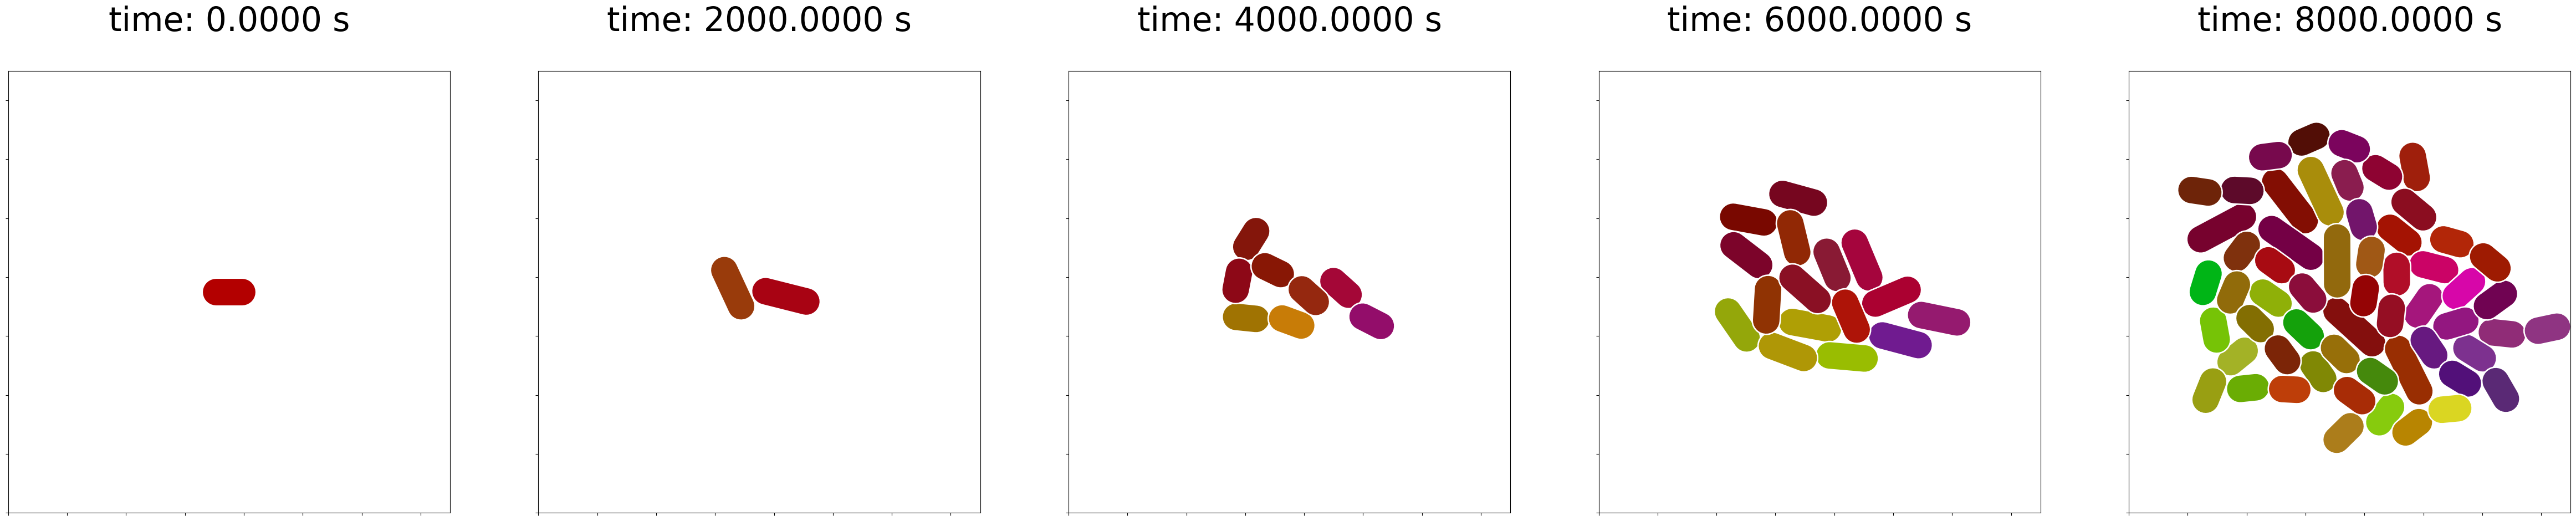

In [22]:
plot_snapshots(plot_data, plot_config)

# 3. Multi-paradigm Composites
 * We here build a hybrid model of a CRN with Bioscrape and flux balance analysis with COBRA.
 * This is demonstated incrementally, by adding one process at a time.
     * Notebook cells need to be run in order to get the expected behavior

In [23]:
# Start with an empty generator. 
# This will be built upon in subsequent cells.
multiclass_composite = Generator()

# Vivarium-Bioscrape
 * Make a Bioscrape process that loads in SBML models with LacY
 * This uses bioCRNpyler to make a model with transporter proteins LacY and PTS, which catalyze the transport of lactose and glucose across the cell membrane. LacY is expressed with a `DNAassembly` that has a `RepressiblePromoter` inhibited by external glucose. When external glucose is depleted, LacY is expressed and lactose can be imported.

In [24]:
###########################################################################################
# Make an SBML file with glucose/lactose transport and expression of the LacY transporter #
###########################################################################################

from biocrnpyler import *
import numpy as np #for arrays
import bioscrape as bs #for simulation
import pandas #stores simulation results

# Create the molecular species
glucose_in = Species("glucose", attributes=['internal'])
glucose_ex = Species("glucose", attributes=['external'])
lactose_in = Species("lactose", attributes=['internal'])
lactose_ex = Species("lactose", attributes=['external'])
LacY = Species("LacY")
PTS = Species("PTS")

# LacY converts lactose_out to lactose_in
lacy_params = {"kb":1e1, "ku":1e-2, "kcat":0.8e1}
pts_params = {"kb":1e1, "ku":1e-2, "kcat":1e1}
LacY_enzyme = Enzyme(LacY, substrate=lactose_ex, product=lactose_in, parameters=lacy_params)
PTS_enzyme = Enzyme(PTS, substrate=glucose_ex, product=glucose_in, parameters=pts_params)

# Michaelis Menten mechanism
mech_mm = MichaelisMenten()

# DNA assembly
promoter_parameters = {
    'k': 1e-4,  # kcat
    'K': 1e-2,  # K_glucose
    'n': 2,
    'kleak': 1e-6}
promoter = RepressiblePromoter('lac_promoter', repressor=glucose_ex, parameters=promoter_parameters, leak=True)
DNA = DNAassembly("lac", promoter=promoter, rbs='rbs', protein=LacY)
mech_tx = SimpleTranscription()
mech_tl = SimpleTranslation()

# Create a mixture named "lactose transport"
default_params = {
    'ktl': 0.25, # translation rate
}
M = Mixture("lactose transport", 
            components = [LacY_enzyme, PTS_enzyme, DNA], 
            mechanisms = [mech_mm, mech_tx, mech_tl],
            parameters=default_params,
           )

# Compile the CRN
CRN = M.compile_crn()
# print(CRN.pretty_print(show_rates = True, show_keys = True))

# write xml file, for import into Bioscrape process
CRN.write_sbml_file('models/lacy.xml')

True

In [25]:
###########################################################
# settings for bioscrape merged into multiclass_composite #
###########################################################

from vivarium_bioscrape.processes.bioscrape import Bioscrape

bioscrape_time_step = 10

initial_state = { 
    'internal': { 
        'dna_lac': 1e-5,
        'PTS': 1e-3,
        'LacY': 0.0},
    'external': {
        'glc__D_e': 1e1,
        'lcts_e': 1e1}}
# configure the simulation with non-spatial environment
bios_composite_settings = {
    'initial_state': initial_state,
    'total_time': 8000,
    'display_info': False,
    'progress_bar': False}

bioscrape_process = Bioscrape({'sbml_file': 'models/lacy.xml'})
species_names = bioscrape_process.get_species_names()
name_map = {
    'lactose_external': 'lcts_e',
    'glucose_external': 'glc__D_e'}
species_mapping = {}
for species in species_names:
    if 'external' in species:
        species_mapping[species] = ('external', name_map.get(species, species))
    else:
        species_mapping[species] = ('internal', name_map.get(species, species))

# exchange deltas connect to flux_bounds in metabolism
flux_names = {
    'lactose_internal': 'EX_lcts_e',
    'glucose_internal': 'EX_glc__D_e'}
flux_mapping = {}
for flux in species_names:
    if flux in flux_names.keys():
        flux_mapping[flux] = ('flux_bounds', flux_names.get(flux, flux))
    else:
        flux_mapping[flux] = ('delta_species', flux)
        
# plotting

plot_var_list = [
    ('internal', 'dna_lac'),
    ('internal', 'rna_lac'),
    ('internal', 'PTS'),
    ('internal', 'LacY'),
    ('internal', 'glucose_internal'),
    ('internal', 'lactose_internal'),
    ('external', 'glc__D_e'),
    ('external', 'lcts_e'),
]


def plot_bioscrape(output):
    fig = plt.figure(figsize=(6, 4))
#     plt.figure()
    time_vec = output['time']
    for (port, var) in plot_var_list:
        plt.plot(time_vec, output[port][var], label = (port, var))
    plt.xlabel('time (sec)')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2)

/Users/eranagmon/.pyenv/versions/3.8.3/envs/bioscrape_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


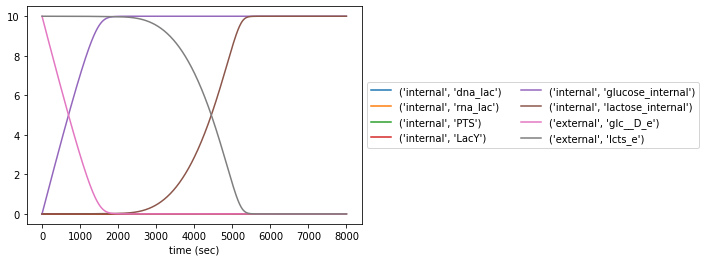

In [26]:
# initialize Bioscrape process with SBML file
bioscrape_process = {
    'bioscrape': Bioscrape({'sbml_file': 'models/lacy.xml', 'time_step': bioscrape_time_step})}

# declare the topology, using modified port mapping
bioscrape_topology = {
    'bioscrape': {
        'species': species_mapping,
        'delta_species': flux_mapping,
        'rates': ('rates',)}}

# merge into multiclass_composite
multiclass_composite.merge(
    processes=bioscrape_process, 
    topology=bioscrape_topology)

output = simulate_compartment_in_experiment(multiclass_composite, bios_composite_settings)
plot_bioscrape(output)

# Metabolism process - Flux Balance Analysis

 * This process is a wrapper for the popular FBA solver [COBRA](https://cobrapy.readthedocs.io/en/latest/).
 * Metabolism is initialized with a [BiGG metabolic model](http://bigg.ucsd.edu) called *iAF1260b*, which has 2382 reactions, 1261 genes, and 166 metabolites.

FBA uses linear optimization to determine fluxes using steady-state assumptions to declare $Sv = 0$, with a distribution of fluxes $v$, across a stoichiometric matrix $S$. 
Constraints are imposed on $v$, setting their upper and lower bounds.

In [27]:
#################################
# settings for metabolism alone #
#################################

import warnings
warnings.filterwarnings('ignore')
from vivarium_cell.processes.metabolism import Metabolism, get_iAF1260b_config

metabolism_time_step = 30

# iAF1260b BiGG model
iAF1260b = get_iAF1260b_config()
target_fluxes = ['EX_lcts_e', 'EX_glc__D_e']
iAF1260b.update({
    'time_step': metabolism_time_step,
    'constrained_reaction_ids': target_fluxes,
    'tolerance': {
        flux: [1.05, 1.0]
        for flux in target_fluxes}})

# configure simulation with a non-spatial environment, using initial state from metabolism
metabolism_process = Metabolism(iAF1260b)
minimal_media = metabolism_process.initial_state()['external']
metabolism_sim_settings = {
    'environment': {
        'volume': 1e-13 * units.L,
        'concentrations': minimal_media},
    'total_time': 2000,
    'display_info': False,
    'progress_bar': False,
}

# plotting function for metabolism output
def plot_metabolism(data, ncol=2):
    original_fontsize = plt.rcParams['font.size']
    plt.rcParams.update({'font.size': 9})
    
    # initialize subplots
    n_rows = 2
    n_cols = 2
    fig = plt.figure(figsize=(n_cols * 7, n_rows * 3))
    grid = plt.GridSpec(n_rows, n_cols)
    
    time_vec = data['time']
    
    # mass
    ax = fig.add_subplot(grid[0, 0])  
    ax.plot(time_vec, data['global']['mass'], label = 'mass')
    ax.set_title('total compartment mass (fg)')
    ax.set_xlabel('time (sec)')
#     ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=ncol)
    
    # external
    ax = fig.add_subplot(grid[0, 1])  
    for mol_id, series in data['external'].items():
        if sum(series) != 0.0:
            ax.plot(time_vec, series, label = mol_id)
    ax.set_title('external concentrations (log)')
    ax.set_yscale('log')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=ncol)
    
    # internal
    ax = fig.add_subplot(grid[1, 1])  
    for mol_id, series in data['internal'].items():
        if sum(series) != 0.0:
            ax.plot(time_vec, series, label = mol_id)
    ax.set_title('internal molecule counts (log)')
    ax.set_xlabel('time (sec)')
    ax.set_yscale('log')
    fig.tight_layout()
    plt.rcParams.update({'font.size': original_fontsize})


/Users/eranagmon/.pyenv/versions/3.8.3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


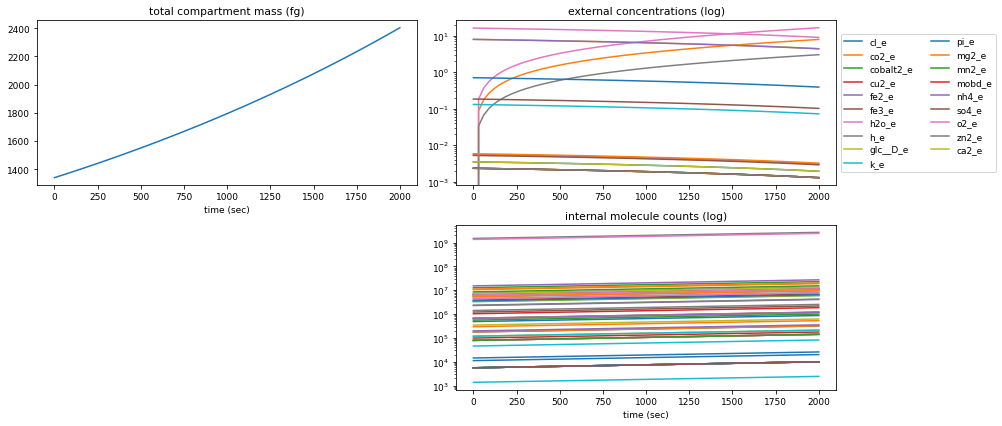

In [28]:
metabolism = Metabolism(iAF1260b)
metabolism_output = simulate_process_in_experiment(metabolism, metabolism_sim_settings)
plot_metabolism(metabolism_output)

# Add Metabolism to the Composite

In [29]:
metabolism_processes = {
    'metabolism': Metabolism(iAF1260b)}

metabolism_topology = {
    'metabolism': {
        'internal': ('internal',),
        'external': ('external',),
        'reactions': ('reactions',),
        'flux_bounds': ('flux_bounds',),
        'global': ('global',),
        'fields': ('fields',),
        'dimensions': ('dimensions',)}}

multiclass_composite.merge(
    processes=metabolism_processes, 
    topology=metabolism_topology)

In [30]:
#######################################
# settings for metabolism + bioscrape #
#######################################

# override emit metabolism internal state (unneeded)
metabolism_schema = metabolism_processes['metabolism'].get_schema()
composite_override = {
    'metabolism': {
        'internal': {
            key: {'_emit': False}
            for key in metabolism_schema['internal'].keys()}}}
multiclass_composite.merge(schema_override=composite_override)

initial_state = {
    'internal': {
        'dna_lac': 1e-5,
        'PTS': 1e-3,
        'LacY': 0,
    },
    'external': {
        'glc__D_e': 1e0,
        'lcts_e': 1e0,
    }}
minimal_media['glc__D_e'] = 1e0
minimal_media['lcts_e'] = 1e0

composite_sim_settings = {
    'environment': {
        'volume': 1e-13 * units.L,
        'concentrations': minimal_media},
    'initial_state': initial_state,
    'total_time': 8000,
    'display_info': False,
    'progress_bar': False,
}

def plot_multiclass_output(data):
    
    original_fontsize = plt.rcParams['font.size']
    plt.rcParams.update({'font.size': 9})
    
    # initialize subplots
    n_rows = 2
    n_cols = 2
    fig = plt.figure(figsize=(n_cols * 6, n_rows * 3))
    grid = plt.GridSpec(n_rows, n_cols)
    
    time_vec = data['time']
    
    
    # mass
    ax = fig.add_subplot(grid[0, 1])  
    ax.plot(time_vec, data['external']['lcts_e'], label = 'lcts_e')
    ax.plot(time_vec, data['external']['glc__D_e'], label = 'glc__D_e')
    ax.legend()
    ax.set_xlabel('time (sec)')
    ax.set_title('external state')
    
    # external
    ax = fig.add_subplot(grid[1, 1])  
    ax.plot(time_vec, data['internal']['LacY'], label = 'LacY')
    ax.plot(time_vec, data['internal']['rna_lac'], label = 'rna_lac')
    ax.set_title('internal state')
    ax.set_xlabel('time (sec)')
    plt.legend()
    
    # internal
    ax = fig.add_subplot(grid[0, 0])  
    ax.plot(time_vec, data['global']['mass'], label = 'mass')
    ax.set_title('global state')
    ax.set_xlabel('time (sec)')
    plt.legend()
    
    fig.tight_layout()
    plt.rcParams.update({'font.size': original_fontsize})

# Run the full hybrid composite

In [31]:
multiclass_composite_output = simulate_compartment_in_experiment(multiclass_composite, composite_sim_settings)

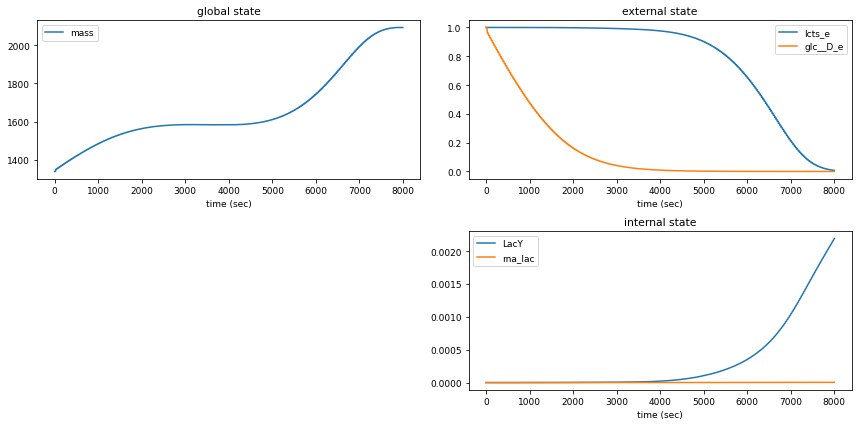

In [32]:
plot_multiclass_output(multiclass_composite_output)